In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import tarfile
import urllib.request

# === Dossier où tu veux stocker les données ===
data_dir = "stanford_dogs"
os.makedirs(data_dir, exist_ok=True)

# === URL de téléchargement (images uniquement) ===
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
filename = os.path.join(data_dir, "images.tar")

# === Étape 1 : Télécharger ===
if not os.path.exists(filename):
    print("Téléchargement en cours...")
    urllib.request.urlretrieve(url, filename)
    print("Téléchargement terminé.")
else:
    print("Fichier déjà téléchargé.")

# === Étape 2 : Extraction ===
extract_path = os.path.join(data_dir, "images")

if not os.path.exists(extract_path):
    print("Extraction en cours...")
    with tarfile.open(filename, "r") as tar:
        tar.extractall(path=data_dir)
    print("Extraction terminée.")
else:
    print("Dossier déjà extrait.")

# === Étape 3 : Exemple d'affichage des classes disponibles ===
classes = sorted(os.listdir(extract_path))
print(f"{len(classes)} classes de chiens trouvées :")
print(classes[:5], "...") 
# 📦 Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 120  # Stanford Dogs Dataset contient 120 races

Téléchargement en cours...
Téléchargement terminé.
Extraction en cours...
Extraction terminée.
120 classes de chiens trouvées :
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu'] ...


In [3]:
import os
import shutil
import random

source_dir = os.path.join(data_dir, "images")
target_dir = "stanford_dogs_split"
train_dir = os.path.join(target_dir, "train")
val_dir = os.path.join(target_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_ratio = 0.8  # 80% train, 20% val

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Créer les dossiers de classe
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copier les images
    for img in train_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Séparation terminée.")


Séparation terminée.


In [ ]:


# 🧰 Prétraitement et augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  
    height_shift_range=0.1,    
    shear_range=0.2,         
    fill_mode='nearest', 
    rescale=1./255  

)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# 🧠 Base ResNet50 sans la tête de classification
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

# Optionnel : ne débloquer que les dernières couches
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 🏗️ Ajout de la tête personnalisée
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# ⚙️ Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#chekcpoint pour eviter le surapprentissage 
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


# 🚀 Entraînement
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
    callbacks=callbacks
)


Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.
Epoch 1/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0096 - loss: 4.8272

c:\Users\lea\Downloads\Refactoring Kata\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


514/514 ━━━━━━━━━━━━━━━━━━━━ 753s 1s/step - accuracy: 0.0107 - loss: 4.7962 - val_accuracy: 0.0115 - val_loss: 4.7842
Epoch 2/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.0121 - loss: 4.7841 - val_accuracy: 0.0123 - val_loss: 4.7820
Epoch 3/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.0124 - loss: 4.7823 - val_accuracy: 0.0123 - val_loss: 4.7808
Epoch 4/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - accuracy: 0.0124 - loss: 4.7813 - val_accuracy: 0.0123 - val_loss: 4.7800
Epoch 5/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.0120 - loss: 4.7803 - val_accuracy: 0.0123 - val_loss: 4.7795
Epoch 6/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.0125 - loss: 4.7800 - val_accuracy: 0.0123 - val_loss: 4.7794
Epoch 7/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.0141 - loss: 4.7740 - val_accuracy: 0.0166 - val_loss: 4.7594
Epoch 8/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.0157 - loss: 4.7628 - val_accuracy: 0.018

In [8]:
model.save("model_chien_resnet50_10epochs.h5")


Epoch 1/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 36868s 72s/step - accuracy: 0.0152 - loss: 4.7545 - val_accuracy: 0.0161 - val_loss: 4.7475
Epoch 2/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - accuracy: 0.0161 - loss: 4.7491 - val_accuracy: 0.0173 - val_loss: 4.7340
Epoch 3/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 713s 1s/step - accuracy: 0.0150 - loss: 4.7504 - val_accuracy: 0.0166 - val_loss: 4.7412
Epoch 4/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.0142 - loss: 4.7514 - val_accuracy: 0.0168 - val_loss: 4.7374
Epoch 5/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 753s 1s/step - accuracy: 0.0157 - loss: 4.7497 - val_accuracy: 0.0178 - val_loss: 4.7356
Epoch 6/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - accuracy: 0.0154 - loss: 4.7477 - val_accuracy: 0.0159 - val_loss: 4.7327
Epoch 7/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.0159 - loss: 4.7488 - val_accuracy: 0.0171 - val_loss: 4.7314
Epoch 8/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 8591s 17s/step - accuracy: 0.0152 - loss: 4.7463 - val

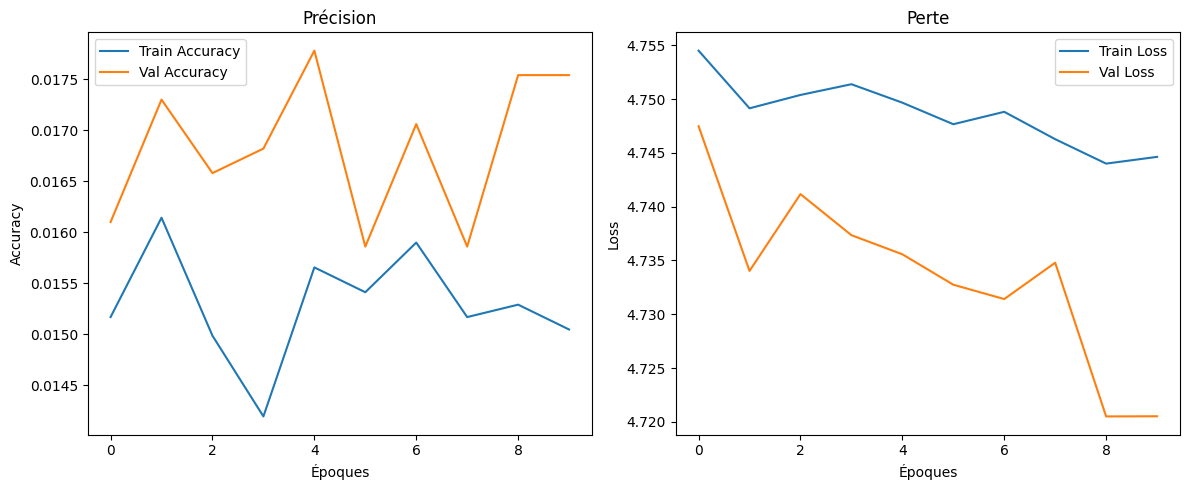

In [9]:
import matplotlib.pyplot as plt

# Entraînement avec récupération de l'historique
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# 📊 Courbes de précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Précision')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

# 📉 Courbes de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Perte')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 790ms/step


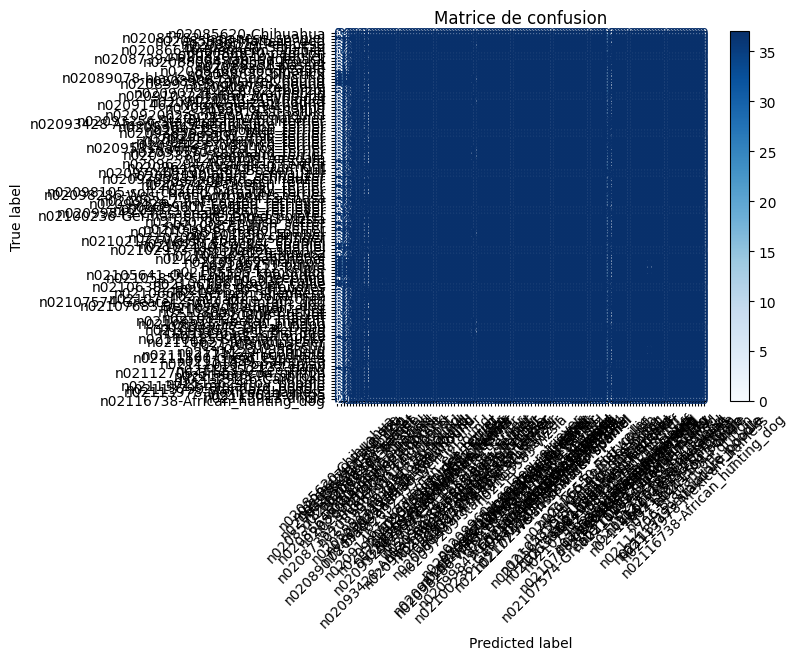

In [11]:
import numpy as np

# Prédictions du modèle
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Vrais labels
y_true = val_generator.classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# 🧰 Prétraitement et augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  
    height_shift_range=0.1,    
    shear_range=0.2,         
    fill_mode='nearest'

)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2 )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 🧠 Base ResNet50 sans la tête de classification
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

# Optionnel : ne débloquer que les dernières couches
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Ajout de la tête personnalisée
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Chekcpoint pour eviter le surapprentissage 
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


# Entraînement
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Found 13172 images belonging to 120 classes.
Found 796 images belonging to 120 classes.


c:\Users\lea\Downloads\Refactoring Kata\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0088 - loss: 4.8489

412/412 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.0112 - loss: 4.7977 - val_accuracy: 0.0151 - val_loss: 5.3420
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0143 - loss: 4.7248

412/412 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.0141 - loss: 4.7172 - val_accuracy: 0.0163 - val_loss: 5.3357
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0164 - loss: 4.6829

412/412 ━━━━━━━━━━━━━━━━━━━━ 1145s 3s/step - accuracy: 0.0171 - loss: 4.6762 - val_accuracy: 0.0176 - val_loss: 4.6676
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0207 - loss: 4.6358

412/412 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - accuracy: 0.0203 - loss: 4.6213 - val_accuracy: 0.0264 - val_loss: 4.5536
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 1259s 3s/step - accuracy: 0.0235 - loss: 4.5723 - val_accuracy: 0.0138 - val_loss: 5.9117
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3025s 7s/step - accuracy: 0.0255 - loss: 4.5407 - val_accuracy: 0.0126 - val_loss: 4.7752
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.0281 - loss: 4.5174 - val_accuracy: 0.0314 - val_loss: 4.7845
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.0282 - loss: 4.4885 - val_accuracy: 0.0239 - val_loss: 4.6773
Epoch 9/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - accuracy: 0.0320 - loss: 4.4577 - val_accuracy: 0.0201 - val_loss: 4.7049


In [19]:
import numpy as np
loss, accuracy = model.evaluate(val_generator)
print(f"Accuracy: {accuracy:.2%}")
print(f"Loss: {loss:.4f}")
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0264 - loss: 4.5536
Accuracy: 2.64%
Loss: 4.5536
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
